<a href="https://colab.research.google.com/github/pavansai26/perfume-classification-using-machine-learning/blob/main/Neural_style.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms , models
from torch.autograd import Variable
import PIL
from PIL import Image
import copy
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Defining the device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
print(device)

cpu


In [ ]:
#defining the output image size
imsize = 200 

#defining the transforms
transform = transforms.Compose([transforms.Resize(imsize) , 
                              transforms.ToTensor()])

#Defining the function to load the images

def image_loader(img_path):
    image = Image.open(img_path)
    image = Variable(transform(image))
    image = image.unsqueeze(0)
    return image
  

In [ ]:
#Defining getting the tensors for style and content image
style_image = image_loader("inputs/starry_night.jpg").type(dtype)
content_image = image_loader("inputs/galaxy.jpg").type(dtype)

assert style_image.size() == content_image.size() ,\
    "Import the images of same size"
print(style_image.size())
print(content_image.size())

torch.Size([1, 3, 200, 200])
torch.Size([1, 3, 200, 200])


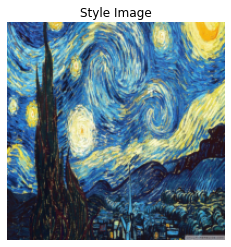

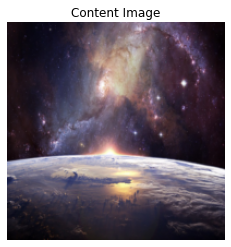

In [ ]:
#Creating a function to diplay ourloaded images

unload =transforms.ToPILImage()

plt.ion()

def imshow(tensor , title = None , result = None):
    image = tensor.cpu().clone() #using clone not affecting the original tensor
    image = image.view(3 , imsize , imsize )
    image = unload(image)
    plt.axis('off')
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    if title == "Stylized Image" and result is not None:
        plt.savefig("Results/results{}.jpg".format(result))

#Style Image
plt.figure()
imshow(style_image , title = "Style Image")

#Content Image
plt.figure()
imshow(content_image , title = "Content Image")
#print(content_image.size())

# Content Loss 

The content Loss is given by the below equation 
![alt text](https://cdn-images-1.medium.com/max/1000/1*2qVOACtvA3m26Q2bP4aN0A.png)

Content loss  is the squared-error loss between the feature representation of the original image and the feature representation of the generated image.



In [ ]:
#Defining the class for content loss

class ContentLoss(nn.Module):

    def __init__(self, target,weight):
        super(ContentLoss, self).__init__()
       
        self.target = target.detach()*weight
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion.forward(input * self.weight , self.target)
        self.output = input
        return self.output
    
    def backward(self , retain_graph = True):
        self.loss.backward(retain_graph = retain_graph)
        return self.loss

# Style Loss

## Gram Matrices

Consider two vectors(more specifically 2 flattened feature vectors from a convolutional feature map of depth C) representing features of the input space, and their dot product give us the information about the relation between them. The lesser the product the more different the learned features are and greater the product, the more correlated the features are. In other words,** the lesser the product, the lesser the two features co-occur and the greater it is, the more they occur together**. This in a sense gives information about an image’s style(texture) and zero information about its spatial structure, since we already flatten the feature and perform dot product on top of it.

Now take all C feature vectors(flattened) from a convolutional feature map of depth C and compute the dot product with every one of them(including with a feature vector itself). **The result is the Gram Matrix(of size CxC**).

The gram matrix is given by the formula in image below

![link text](https://cdn-images-1.medium.com/max/1000/1*C3fkQanKHMwOi_rf0q0OQQ.png)

## Style Loss Function

The style loss is the mean-squared distance between the style representation (gram matrix) of the style image and the style representation of the output image in one layer l.

![alt text](https://cdn-images-1.medium.com/max/1000/1*66C6jaZcdEuxUoBvXVuPhQ.png)

We apply the loss function on different layers to get the total loss.

![alt text](https://cdn-images-1.medium.com/max/1000/1*6ZqgAS5gDn25jncXDRfqog.png)

In [ ]:
#Defining the function to define the gram matrix

class gram_matrix(nn.Module):
    def forward(self , input):
        a, b, c, d = input.size()  # a=batch size(=1)
        # b=number of feature maps
        # (c,d)=dimensions of a f. map (N=c*d)

        features = input.view(a * b, c * d)  

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * b * c * d)

In [ ]:
#Defining the class for style loss

class StyleLoss(nn.Module):

    def __init__(self, target ,weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach()*weight
        self.weight = weight
        self.Gram = gram_matrix()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.output = input.clone()
        self.G = self.Gram.forward(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G ,self.target)
        return self.output
    
    def backward(self , retain_graph = True):
        self.loss.backward(retain_graph = retain_graph)
        return self.loss

In [ ]:
#Importing the pretrained model (The paper uses VGG19 model)

cnn = models.vgg19(pretrained  = True).features.to(device)
print(cnn)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:

# desired depth layers to compute style/content losses :
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# just in order to have an iterable access to or list of content/syle losses
content_losses = []
style_losses = []

model = nn.Sequential()  # the new Sequential module network
gram = gram_matrix()  # we need a gram module in order to compute style targets

# move these modules to the GPU if possible:
if torch.cuda.is_available():
    model = model.cuda()
    gram = gram.cuda()

# weigth associated with content and style losses
content_weight = 1
style_weight = 1000

i = 1
for layer in list(cnn):
    if isinstance(layer, nn.Conv2d):
        name = "conv_" + str(i)
        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model.forward(content_image).clone()
            content_loss = ContentLoss(target, content_weight)
            model.add_module("content_loss_" + str(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model.forward(style_image).clone()
            target_feature_gram = gram.forward(target_feature)
            style_loss = StyleLoss(target_feature_gram, style_weight)
            model.add_module("style_loss_" + str(i), style_loss)
            style_losses.append(style_loss)

    if isinstance(layer, nn.ReLU):
        name = "relu_" + str(i)
        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model.forward(content_image).clone()
            content_loss = ContentLoss(target, content_weight)
            model.add_module("content_loss_" + str(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model.forward(style_image).clone()
            target_feature_gram = gram.forward(target_feature)
            style_loss = StyleLoss(target_feature_gram, style_weight)
            model.add_module("style_loss_" + str(i), style_loss)
            style_losses.append(style_loss)

        i += 1

    if isinstance(layer, nn.MaxPool2d):
        name = "pool_" + str(i)
        model.add_module(name, layer) 

/home/ubuntu/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448216815/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


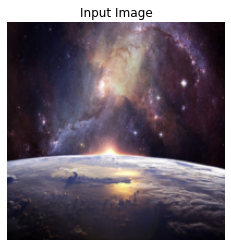

In [ ]:
inp_img = content_image.clone()
plt.figure()
imshow(inp_img , title = "Input Image")

In [ ]:
#Defining the input to the optimizer , the author of the paper suggests to use BFGS optimizer

inp = nn.Parameter(inp_img.data)
optimizer = optim.LBFGS([inp])

Building the style transfer model
Run : [50]
Style_loss : 3.317685 || Content_loss : 4.674718

Run : [100]
Style_loss : 0.751401 || Content_loss : 4.115999

Run : [150]
Style_loss : 0.525317 || Content_loss : 3.728786

Run : [200]
Style_loss : 0.368413 || Content_loss : 3.563439

Run : [250]
Style_loss : 0.283139 || Content_loss : 3.490637

Run : [300]
Style_loss : 0.240601 || Content_loss : 3.447259

Run : [350]
Style_loss : 0.243107 || Content_loss : 3.420441

Run : [400]
Style_loss : 0.255389 || Content_loss : 3.392149

Run : [450]
Style_loss : 0.318857 || Content_loss : 3.384148

Run : [500]
Style_loss : 0.248014 || Content_loss : 3.363196



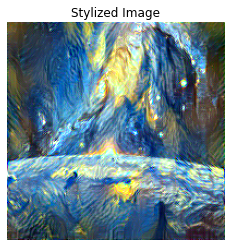

In [ ]:
# The style Transfer Process
num_runs = 500
print("Building the style transfer model")
    
run = [0]
while run[0] <= num_runs:       
        def closure():
            inp.data.clamp_(0,1)
            optimizer.zero_grad()
            model.forward(inp)
            style_score = 0
            content_score = 0
            
            for sl in style_losses:
                style_score += sl.backward()
            for cl in content_losses:
                content_score += cl.backward()
            
            
            
            run[0] += 1
            if run[0] % 50 == 0:
                print("Run : {}".format(run))
                print("Style_loss : {:4f} || Content_loss : {:4f}".format(style_score.item() , content_score.item()))
                print()
            return style_score + content_score
        optimizer.step(closure)
       
# last correction
inp.data.clamp_(0,1)
#Displaying the results
plt.figure()
imshow(inp.data , title  = "Stylized Image" , result = 'new')
#plt.plt.savefig("Results_macchu.jpg")
plt.ioff()

    